In [1]:
import os
import torch 
from torch import nn
import torch.nn.functional as F
from sklearn import preprocessing
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score

In [2]:
from data_cleaning import clean, seq_gen, get_Xy, make_homogenous_sequence

In [151]:
FILE_LOCATION=r'C:\Users\Asus\Videos\paper lstm transform\rethesis2014arnab\NonSMOTE\NonSMOTE\yeast5\yeast5-5-fold'
TRAIN_DATA='yeast5-5-5tra.dat'
TEST_DATA='yeast5-5-5tst.dat'
TRAIN_DATA_=os.path.join(FILE_LOCATION,TRAIN_DATA)
TEST_DATA_=os.path.join(FILE_LOCATION, TEST_DATA)

In [152]:
train_data=clean(TRAIN_DATA_)

In [153]:
train_data.head()

,0,1,2,3,4,5,6,7,8
0,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22,0
1,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22,0
2,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22,0
3,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22,0
4,0.51,0.40,0.56,0.17,0.5,0.5,0.49,0.22,0


In [154]:
def seq_generation(data, pos=0, mj=0, mn=1):
    '''
    input: data of DataFrame, mj: majority class label, mn: minority class label
    
    output: numpy tensor of shape (timsteps, 2*min_sample_size, features)
            at each timestep, majority class and minority class samples distribution is equal
    '''
    data_mj=data[data[str(len(data.columns)-1)]==mj]
    data_mj=np.array(data_mj)
    data_mn=data[data[str(len(data.columns)-1)]==mn]
    data_mn=np.array(data_mn)
    
    majority_data_iterator=0
    
    '''seq_len is the number of timesteps.'''

    seq_len=(data_mj.shape[0]//data_mn.shape[0])+1

    '''batch_size = number of minority samples'''
    #print('data_mj shape:', data_mj.shape)
    #print('data_mn shape:', data_mn.shape)
    
    batch_size=data_mn.shape[0]
    #print('batch_size:', batch_size)
    seq=np.zeros((seq_len, data_mn.shape[0], data_mn.shape[1]))
    #print('sequence shape:', seq.shape)
    #print('data_mj[]:', data_mj[2*batch_size:2*batch_size+batch_size].shape)
    
    for i in range(seq_len):
        if i!=pos:
            seq[i]=data_mj[(majority_data_iterator*batch_size):( (majority_data_iterator*batch_size)+batch_size)]
            majority_data_iterator+majority_data_iterator+1
            
        else:
            seq[i]=data_mn
            #print('data')
            #print(seq[i].shape)
    return seq

In [155]:
seq=seq_generation(train_data,0)

In [156]:
trainx,trainy=get_Xy(seq)

In [157]:
trainx=torch.from_numpy(trainx).float()
trainy=torch.from_numpy(trainy).float()

In [158]:
test_data=clean(TEST_DATA_).values
testx=torch.from_numpy(test_data[:,:-1]).float()
testy=torch.from_numpy(test_data[:,-1]).float()

In [159]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm=nn.LSTMCell(8,32)
        self.l=nn.Linear(32,1)
    
    def forward(self,x):
        output,_=self.lstm(x)
        output=self.l(output)
        
        return output

In [160]:
m=Model()

In [161]:
criterion=nn.BCEWithLogitsLoss()
optimizer=torch.optim.SGD(m.parameters(),lr=0.09)

In [162]:
from torch.autograd import Variable
def train_epoch(model,optim,criterion,trainx,trainy):
    model.train()
    loss=0
    losses=[]
    optim.zero_grad()
    l=0
    for i in range(trainx.shape[0]):
        n=model(trainx[i])
        l=l+criterion(n,trainy[i].view(trainy[i].shape[0],1))
        #l.backward(retain_graph=True) #this works too
        
        #if i==(trainx.shape[0]-1):
         #   losses.append(l.data.numpy())
    losses.append(l.data.numpy())
    loss=l
    loss.backward()
    optim.step()

    return losses

In [163]:
e_losses = []
num_epochs = 20
for i in range(2000):
    
    train_seq=seq_generation(train_data,i%32)
    trainx, trainy=get_Xy(train_seq)
    trainx=torch.from_numpy(trainx).float()
    trainy=torch.from_numpy(trainy).float()
    e_losses+=train_epoch(m,optimizer,criterion,trainx,trainy)

In [164]:
import matplotlib.pyplot as plt

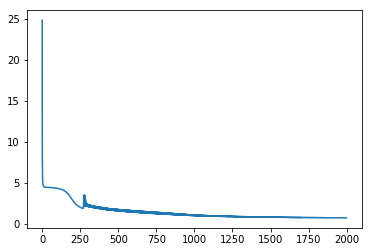

In [165]:
plt.plot(e_losses)

In [166]:
m.eval()

with torch.no_grad():
    logit_predictions=m(testx)
    prediction_probabilities=torch.sigmoid(logit_predictions)
    
    preds=torch.round(prediction_probabilities)
    

In [167]:
f1_score(preds,testy)

0.4999999999999999

In [77]:
5%14

5